In [14]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>
[nltk_data] Error loading wordnet: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [15]:
data_dir = 'E:\Work_DatPT\Study\Master'
df_train = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel.csv')
df_train.head()


,httprequest,label
0,GET /tiki-listmovies.php?movie=../../../../../...,272 - Protocol Manipulation
1,GET /tiki-listmovies.php?movie=../../../../../...,88 - OS Command Injection
2,GET /tiki-listmovies.php?movie=../../../../../...,126 - Path Traversal
3,GET /tiki-listmovies.php?movie=../../../../../...,310 - Scanning for Vulnerable Software
4,"GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxK...",272 - Protocol Manipulation


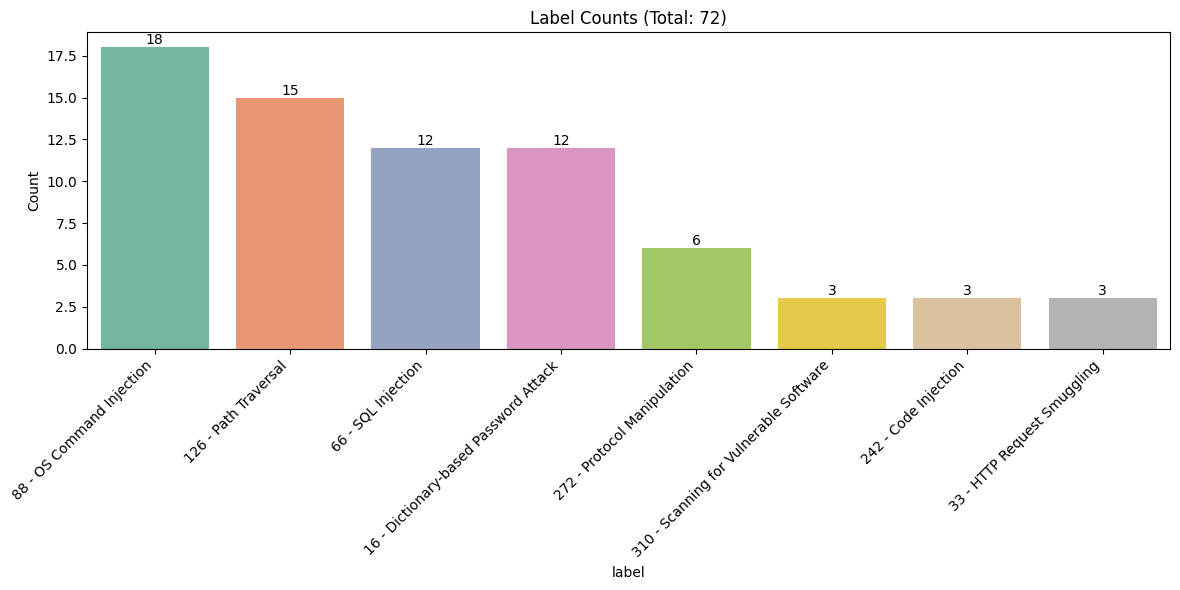

In [16]:
label_counts = df_train['label'].value_counts()

# Create a color palette for the bars
colors = sns.color_palette("Set2", len(label_counts))

# Create a bar chart with specified colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Add labels to the bars
for i, (label, count) in enumerate(label_counts.items()):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Customize the chart
total_count = label_counts.sum()
plt.title(f'Label Counts (Total: {total_count})')
plt.ylabel('Count')

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Show the chart
plt.tight_layout()
plt.show()


In [17]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, classification_report


data = df_train

X = data[['httprequest']]
y = data['label']



In [18]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [19]:
# import lightgbm as lgb
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import accuracy_score

# # Đọc dữ liệu từ tệp CSV
# data = df_train

# X = data[['httprequest']]
# y = data['label']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
# clf = lgb.LGBMClassifier()
# clf.fit(X_train, y_train)
# y_pred=clf.predict(X_test)
# accuracy=accuracy_score(y_pred, y_test)
# print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))


# # Data preprocessing
# # le = LabelEncoder()
# # data['httprequest'] = le.fit_transform(data['httprequest'])
# # data['label'] = le.fit_transform(data['label'])

# # # Split data into training and testing sets
# # X_train, X_test, y_train, y_test = train_test_split(data.drop('label', axis=1), data['label'], test_size=0.2, random_state=42)

# # # Create datasets
# # train_data = lgb.Dataset(X_train, label=y_train)
# # valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# # # Define model parameters
# # params = {
# #     "objective": "multiclass",
# #     "num_class": 10,  # Replace with the number of classes in your dataset
# #     "metric": "multi_logloss",
# #     "early_stopping_round": 50,  # Set the number of early stopping rounds
# #     "boosting_type": "gbdt",
# #     "num_leaves": 31,
# #     "verbose_eval": 10,
# #     "learning_rate": 0.05,
# # }

# # # Train the model
# # num_round = 1000
# # bst = lgb.train(params, train_data, num_round, valid_sets=[valid_data])

# # # Get the best iteration
# # best_iteration = bst.best_iteration

# # # Predict and evaluate
# # y_pred = bst.predict(X_test, num_iteration=best_iteration)
# # y_pred = [list(x).index(max(x)) for x in y_pred]

# # accuracy = accuracy_score(y_test, y_pred)
# # print(f'Accuracy: {accuracy}')

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df_train["httprequest"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
# Optional (not effect very much)
df_train['httprequest'] = df_train['httprequest'].str.replace('/',' ')
df_train.head()

,httprequest,label
0,GET tiki-listmovies.php?movie=.. .. .. .. .. ...,272 - Protocol Manipulation
1,GET tiki-listmovies.php?movie=.. .. .. .. .. ...,88 - OS Command Injection
2,GET tiki-listmovies.php?movie=.. .. .. .. .. ...,126 - Path Traversal
3,GET tiki-listmovies.php?movie=.. .. .. .. .. ...,310 - Scanning for Vulnerable Software
4,"GET zimbra res I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxK...",272 - Protocol Manipulation


## Naive Bayes Classifier

In [25]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["httprequest"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))


0.0


## Random Forest Classifier

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.0
